In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import ast

import matplotlib.pyplot as plt
import numpy as np

from configs import load_configs, load_experimental_results

In [15]:
all_configs = load_configs("debug_experiment")
res = load_experimental_results(all_configs)
final_res = load_experimental_results(all_configs, final=True)

In [16]:
columns = [col for col in res.columns if col not in ['seed', 'id', 'loss', 'weighted_loss']]

In [36]:
mean = final_res.groupby(columns)[['loss', 'weighted_loss']].mean().reset_index()
std = final_res.groupby(columns)[['loss', 'weighted_loss']].std().reset_index()

mean['input_divisors'] = mean['input_divisors'].apply(lambda x: np.array(ast.literal_eval(x)))
mean['output_divisors'] = (mean['input_divisors'] * mean['compression_rate']).apply(lambda x: x.astype(int))
mean['complexity'] = (mean['input_divisors'] * mean['output_divisors']).apply(lambda x: x.sum())

std['complexity'] = mean['complexity']

# mean.loc[mean['random'] == True, 'complexity'] = 2000
random_mean = mean[mean['random'] == True]
random_std = std[std['random'] == True]

mean = mean[mean['random'] == False]
std = std[std['random'] == False]

In [37]:
mean.set_index('complexity', inplace=True)
std.set_index('complexity', inplace=True)

mean.sort_index(inplace=True)
std.sort_index(inplace=True)

In [44]:
print(mean[['loss', 'weighted_loss']])
print(mean['loss'] - std['loss'])
print(mean['loss'] + std['loss'])

                loss  weighted_loss
complexity                         
17          0.000022       0.000002
21          0.000043       0.000002
30          0.000032       0.000002
55          0.000038       0.000002
82          0.000072       0.000003
109         0.000036       0.000002
203         0.000083       0.000003
452         0.000068       0.000003
1800        0.000132       0.000005
complexity
17      0.000003
21      0.000011
30      0.000012
55      0.000015
82      0.000037
109     0.000018
203     0.000048
452     0.000044
1800    0.000096
Name: loss, dtype: float32
complexity
17      0.000041
21      0.000074
30      0.000052
55      0.000061
82      0.000107
109     0.000055
203     0.000118
452     0.000092
1800    0.000168
Name: loss, dtype: float32


[]

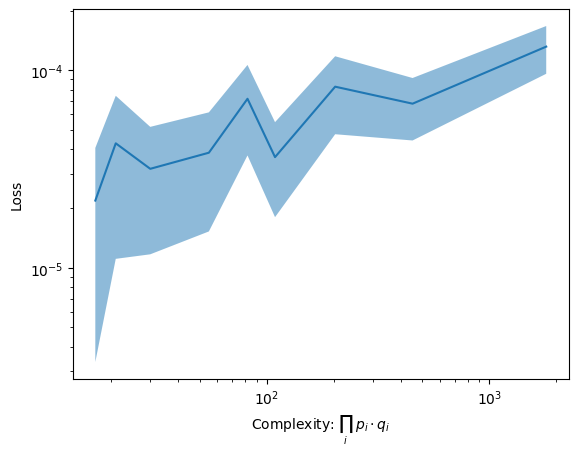

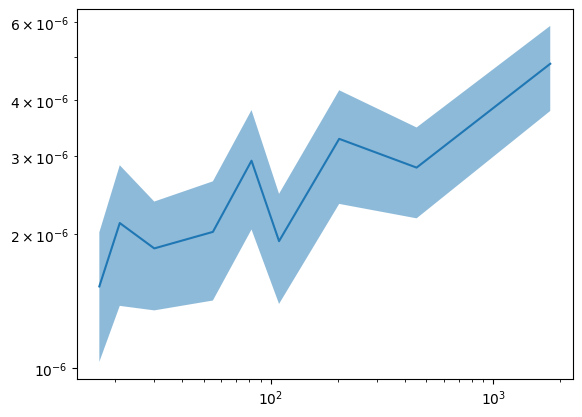

In [55]:

plt.plot(mean['loss'])
plt.fill_between(mean.index, mean['loss'] - std['loss'], mean['loss'] + std['loss'], alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Complexity: $\prod_i\ p_i\cdot q_i$')
plt.ylabel('Loss')

plt.figure()
plt.plot(mean.index, mean['weighted_loss'])
plt.fill_between(mean.index, mean['weighted_loss'] - std['weighted_loss'], mean['weighted_loss'] + std['weighted_loss'], alpha=0.5)
plt.loglog()